* 选用不同特征集
* 重新划分测试集进行测试
    * 训练集01 2013-01 至 2017-07, 测试集 2017-08
    * 训练集02 2013-01 至 2017-08, 测试集 2017-09
    * 训练集03 2013-01 至 2017-09, 测试集 2017-10
* 后面再重新划分训练集, 最好选用相同时长, 测试结果最佳为宜
* 测试一下去掉去年总销量的 LightGBM
* 测试 XGBoost/LightGBM
* 测试一下改变训练集
    * 训练集01 2013-08 至 2017-07, 测试集 2017-08
    * 训练集02 2013-09 至 2017-08, 测试集 2017-09
    * 训练集03 2013-10 至 2017-09, 测试集 2017-10
* 只保留平均数试试, 看到 Kaggle 的启发, 没有什么效果
* 去掉 6 月的时间窗口, Average RMSE 121, 区别也不大
* 发现 12月前销量数据对 LightGBM 模型影响挺大, 试试增加 2/3/6 时间窗口数据, 没有任何效果

# 选用带时间窗口, 带同比/环比数据集 特征集测试

In [589]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [590]:
data = pd.read_csv('../../raw/LiChuan/dataset.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [591]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [592]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

## 测试 LightGBM

In [593]:
lgb_train_1 = lgb.Dataset(train_1, labels_1)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_1 = lgb.train(params, lgb_train_1, 900)
lgb_pred_1 = model_1.predict(test_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 124.901886283


In [594]:
lgb_train_2 = lgb.Dataset(train_2, labels_2)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_2 = lgb.train(params, lgb_train_2, 1000)
lgb_pred_2 = model_2.predict(test_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 112.545135865


In [595]:
lgb_train_3 = lgb.Dataset(train_3, labels_3)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_3 = lgb.train(params, lgb_train_3, 1145)
lgb_pred_3 = model_3.predict(test_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 125.921551568


In [596]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 121.122857905


* 加上同比/环比 特征 LightGBM 测试的效果不错
* 稍微变化一下训练集, 效果没什么变化
* 去掉环比, LGB 效果居然下降了和 XGBoost 不同

Features importance...
                            feature       gain  split
159       sale_quantity_last_3M_sum  37.788769    781
144   sale_quantity_this_last_month  14.117748   3739
171       sale_quantity_last_2M_sum   9.948183    849
162      sale_quantity_last_3M_mean   8.340044    154
170    sale_quantity_last_6M_median   7.487724   1253
183      sale_quantity_last_12M_ago   4.772361   2484
161       sale_quantity_last_3M_min   2.689271   1114
174      sale_quantity_last_2M_mean   2.024896    175
164    sale_quantity_last_3M_median   1.851267   1202
113                           month   1.524849   5779
177      sale_quantity_last_12M_sum   1.513910    589
173       sale_quantity_last_2M_min   1.354212   1182
160       sale_quantity_last_3M_max   0.655480    576
184    month_relative_ratio_12M_ago   0.637789   1900
145  sale_quantity_total_last_month   0.599437   3033
178      sale_quantity_last_12M_max   0.473822    423
172       sale_quantity_last_2M_max   0.459403    548
182  

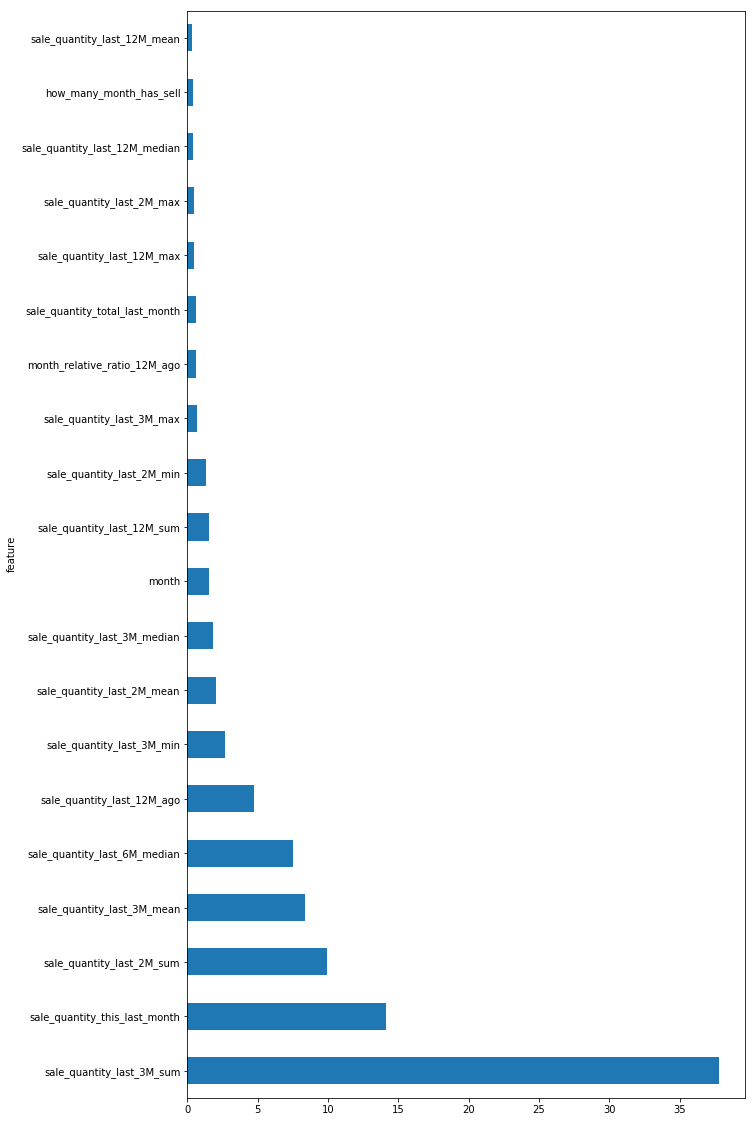

In [597]:
print("Features importance...")
gain = model_3.feature_importance('gain')
ft = pd.DataFrame({'feature':model_3.feature_name(), 'split':model_3.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft.head(25))

plt.figure()
ft[['feature','gain']].head(20).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 20))
plt.gcf().savefig('features_importance.png')

* 居然是时间窗口的重要性最大
* 考虑是不是增加时间窗口

## 测试 XGBoost

In [27]:
trainset_1 = xgb.DMatrix(train_1, label=labels_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=4000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 189.132249402


In [29]:
trainset_2 = xgb.DMatrix(train_2, label=labels_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=4000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 136.468074536


In [30]:
trainset_3 = xgb.DMatrix(train_3, label=labels_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=4000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 144.117899382


In [31]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 156.572741106


* 选取全特征, 加上同比/环比 数据, XGBoost 模型效果较差, 不使用这样的特征

# 选用带时间窗口, 不带同比/环比数据集 特征集测试

In [34]:
data = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [35]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [36]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-560]
test_1 = data[-560:-420]
labels_1 = labels[:-560]
test_labels_1 = labels[-560:-420]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-420]
test_2 = data[-420:-280]
labels_2 = labels[:-420]
test_labels_2 = labels[-420:-280]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-280]
test_3 = data[-280:-140]
labels_3 = labels[:-280]
test_labels_3 = labels[-280:-140]

## 测试 LightGBM

In [38]:
lgb_train_1 = lgb.Dataset(train_1, labels_1)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_1 = lgb.train(params, lgb_train_1, 900)
lgb_pred_1 = model_1.predict(test_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 145.116054859


In [39]:
lgb_train_2 = lgb.Dataset(train_2, labels_2)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_2 = lgb.train(params, lgb_train_2, 900)
lgb_pred_2 = model_2.predict(test_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 116.378154374


In [40]:
lgb_train_3 = lgb.Dataset(train_3, labels_3)

params = {
'learning_rate': 0.003,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 30,
'min_hessian': 1,
'verbose': -1,}

model_3 = lgb.train(params, lgb_train_3, 900)
lgb_pred_3 = model_3.predict(test_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 150.31146246


In [41]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 137.268557231


* LightGBM 效果不如加上同比/环比 特征

## 测试 XGBoost

In [42]:
trainset_1 = xgb.DMatrix(train_1, label=labels_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=4000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 193.746542278


In [43]:
trainset_2 = xgb.DMatrix(train_2, label=labels_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=4000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 135.365487254


In [44]:
trainset_3 = xgb.DMatrix(train_3, label=labels_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=4000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 131.289320436


In [45]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 153.467116656


* 比上面加同比/环比, 略微强一点

# 不带时间窗口特征

In [46]:
data = pd.read_csv('../../raw/LiChuan/trainSaleDate.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [52]:
# 去掉 2012 年数据
data = data[data['year'] != 2012]
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [54]:
# 训练集 2013-01 至 2017-07, 测试集 2017-08
train_1 = data[:-420]
test_1 = data[-420:-280]
labels_1 = labels[:-420]
test_labels_1 = labels[-420:-280]

# 训练集 2013-01 至 2017-08, 测试集 2017-09
train_2 = data[:-280]
test_2 = data[-280:-140]
labels_2 = labels[:-280]
test_labels_2 = labels[-280:-140]

# 训练集 2013-01 至 2017-09, 测试集 2017-10
train_3 = data[:-140]
test_3 = data[-140:]
labels_3 = labels[:-140]
test_labels_3 = labels[-140:]

## 测试 LightGBM

In [56]:
lgb_train_1 = lgb.Dataset(train_1, labels_1)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_1 = lgb.train(params, lgb_train_1, 900)
lgb_pred_1 = model_1.predict(test_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 152.625651074


In [57]:
lgb_train_2 = lgb.Dataset(train_2, labels_2)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model_2 = lgb.train(params, lgb_train_2, 900)
lgb_pred_2 = model_2.predict(test_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - lgb_pred_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 120.574974352


In [58]:
lgb_train_3 = lgb.Dataset(train_3, labels_3)

params = {
'learning_rate': 0.003,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 30,
'min_hessian': 1,
'verbose': -1,}

model_3 = lgb.train(params, lgb_train_3, 900)
lgb_pred_3 = model_3.predict(test_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - lgb_pred_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 160.703307873


In [59]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 144.634644433


## 测试 XGBoost

In [60]:
trainset_1 = xgb.DMatrix(train_1, label=labels_1)
testset_1 = xgb.DMatrix(test_1)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_1 = xgb.train(params, trainset_1, num_boost_round=4000)
predict_xgb_1 = model_1.predict(testset_1)
rmsetmp_1 = sp.sqrt(sp.mean((test_labels_1 - predict_xgb_1) ** 2))

print('This time rmse is: '+ str(rmsetmp_1))

This time rmse is: 140.010796927


In [61]:
trainset_2 = xgb.DMatrix(train_2, label=labels_2)
testset_2 = xgb.DMatrix(test_2)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_2 = xgb.train(params, trainset_2, num_boost_round=4000)
predict_xgb_2 = model_2.predict(testset_2)
rmsetmp_2 = sp.sqrt(sp.mean((test_labels_2 - predict_xgb_2) ** 2))

print('This time rmse is: '+ str(rmsetmp_2))

This time rmse is: 163.353862481


In [62]:
trainset_3 = xgb.DMatrix(train_3, label=labels_3)
testset_3 = xgb.DMatrix(test_3)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model_3 = xgb.train(params, trainset_3, num_boost_round=4000)
predict_xgb_3 = model_3.predict(testset_3)
rmsetmp_3 = sp.sqrt(sp.mean((test_labels_3 - predict_xgb_3) ** 2))

print('This time rmse is: '+ str(rmsetmp_3))

This time rmse is: 152.222508663


In [63]:
print('The average rmse is: '+ str((rmsetmp_1 + rmsetmp_2 + rmsetmp_3)/3))

The average rmse is: 151.862389357


* XGBoost 效果似乎也不咋地

In [ ]:
rmse_1 = sp.sqrt(sp.mean((lgb_pred_1 - predict_xgb_1) ** 2))

rmse_2 = sp.sqrt(sp.mean((lgb_pred_2 - predict_xgb_2) ** 2))

rmse_3 = sp.sqrt(sp.mean((lgb_pred_3 - predict_xgb_3) ** 2))

print(rmse_1, rmse_2, rmse_3)

## 不带时间窗口, 带同比, 不带环比的 XGBosst

* 为了得到 XGBoost 的提交文件

In [666]:
train = pd.read_csv('../../raw/LiChuan/trainSaleDate.csv')
test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [667]:
train['sale_date'] = train['year'] * 100 + train['month']
train['sale_date'] = train['sale_date'].astype(int)
train['sale_date'] = pd.to_datetime(train['sale_date'],format='%Y%m',errors = "coerce")
train['sale_date'] = train['sale_date'].dt.to_period('m')

In [668]:
test['sale_date'] = test['sale_date'].astype(int)
test['sale_date'] = pd.to_datetime(test['sale_date'],format='%Y%m',errors = "coerce")
test['sale_date'] = test['sale_date'].dt.to_period('M')

In [669]:
train = pd.concat([train, test]).reset_index(drop=True)
train.fillna(0, inplace=True)

In [670]:
train.shape,test.shape

((9940, 163), (140, 162))

In [671]:
# 获取 12 月前的销量
i = train['sale_date'][0]+11
window = [i-11]
traintmp = pd.DataFrame()
for i in range(59):
    trainSaletmp = train[train['sale_date'].isin(window)]
    trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
    trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).sale_quantity.reset_index()
    trainSaletmp['sale_date'] = window[0]+12
    if i == 0:
        traintmp = trainSaletmp
    else:
        traintmp = pd.concat([traintmp, trainSaletmp])
    for j,k in enumerate(window):
        window[j] = window[j] + 1

In [672]:
traintmp.rename(columns={'sale_quantity': 'sale_quantity_last_12M_ago'}, inplace=True)# 替换列名称
train = pd.merge(train, traintmp, on=['class_id','sale_date'], how='left')
train['sale_quantity_last_12M_ago'].fillna(0, inplace=True)

In [675]:
train_2 = train[:-420]
test_2 = train[-420:-280]

In [631]:
# 保存一下 XGBoost 的 features
# train.to_csv('../../raw/LiChuan/XGBoostFeatures.csv',index=False, header=True)

In [632]:
train = train[train['year'] != 2012]
labels = train['sale_quantity'][:-140]
train = train.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [633]:
test = train[-140:].reset_index(drop=True)
train = train[:-140].reset_index(drop=True)

In [634]:
trainset = xgb.DMatrix(train,label=labels)
testset = xgb.DMatrix(test)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=3000)
predict_xgb = model.predict(testset)

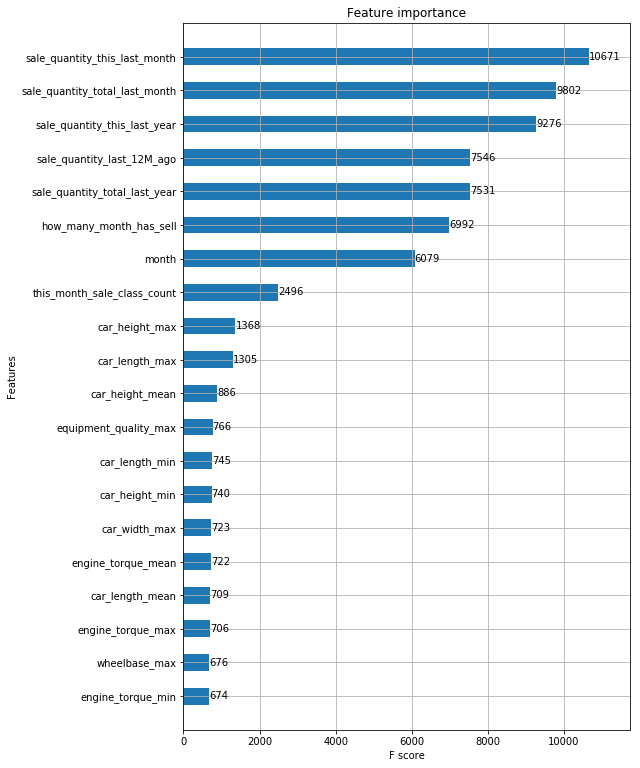

In [635]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

In [637]:
lgb = pd.read_csv('../../raw/LiChuan/result_180223_lightGBM.csv')
predict_lgb = lgb['predict_quantity']

In [638]:
base = pd.read_csv('../../raw/Submissions/result_180222_baseline_RMSE131.csv')
predict_base = base['predict_quantity']

In [682]:
sp.sqrt(sp.mean((predict_base - predict_lgb) ** 2))

99.539129482382009

In [681]:
sp.sqrt(sp.mean((predict_lgb - predict_xgb) ** 2))

94.339868161293722

In [677]:
predictions = predict_base*0.42 + predict_lgb*0.58

In [678]:
submit['predict_quantity'] = predictions
submit.to_csv('../../raw/LiChuan/result_180224_baseline*0.42_lightGBM*0.58.csv',index=False, header=True)  